In [1]:
import numpy as np  # linear alg
import pandas as pd  # data processing 
import os
from glob import glob  # file searching
%matplotlib inline
import matplotlib.pyplot as plt  # plotting

In [2]:
# Setting up access to the images and csv

PATH = os.path.abspath('./data')
SOURCE_IMAGES = os.path.join(PATH, "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))
xray_labels_df = pd.read_csv(os.path.join(PATH, 'sample_labels.csv'))

In [3]:
all_image_paths = {os.path.basename(x): x for x in images}
image_names = [os.path.basename(x) for x in images]

# Removes rows from dataframe that do not have a corresponding image in the images folder.
xray_labels_df = xray_labels_df[xray_labels_df['Image Index'].isin(image_names)]

print(len(xray_labels_df))
# Add the path to all images to the dataframe
xray_labels_df['path'] = xray_labels_df['Image Index'].map(all_image_paths.get)
xray_labels_df.sample(3)

# Fix Patient Age to be just a number
# xray_labels_df['Patient Age'] = xray_labels_df['Patient Age'].map(lambda x: int(x[:-1]))
# xray_labels_df.sample(3)

20000


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89477,00022208_010.png,Infiltration,10,22208,50,M,PA,2992,2991,0.143,0.143,NaN,/Users/aculanay/Desktop/Spring 2018/CSC665-AI/...
100853,00026793_004.png,Emphysema|Pneumothorax,4,26793,63,M,PA,2992,2991,0.143,0.143,NaN,/Users/aculanay/Desktop/Spring 2018/CSC665-AI/...
95215,00024928_000.png,No Finding,0,24928,28,M,PA,3056,2544,0.139,0.139,NaN,/Users/aculanay/Desktop/Spring 2018/CSC665-AI/...


Preprocessing:
-------------

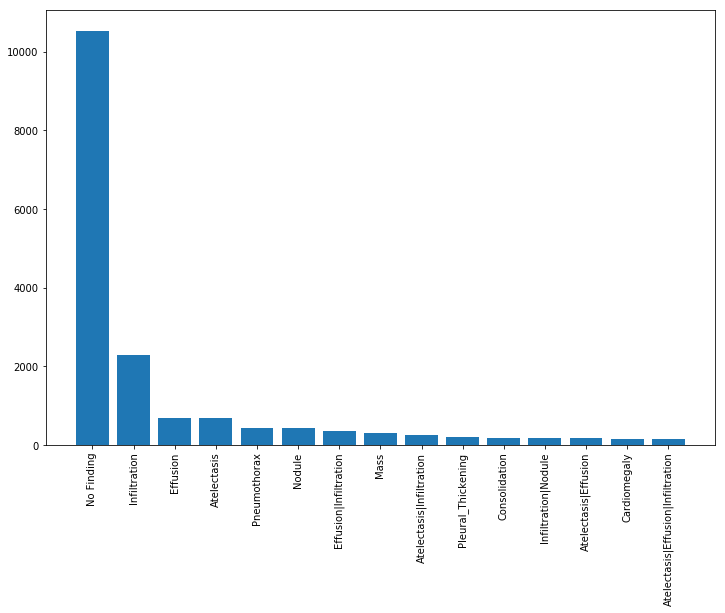

In [4]:
# Get the number of each type of disease classification
label_counts = xray_labels_df['Finding Labels'].value_counts()[:15]

# plot it
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
# Rotate and space out the labels to make them readable
ax1.bar(np.arange(len(label_counts)) + 1.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 1.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)

In [5]:
from itertools import chain

xray_labels_df['Finding Labels'] = xray_labels_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

all_labels = np.unique(list(chain(*xray_labels_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

# Adds attributes for each possible finding, and assigns value of 1.0 for each finding
# in the Finding Label (1-Hot Encoding)
for c_label in all_labels:
    if len(c_label) > 1:
        xray_labels_df[c_label] = xray_labels_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

xray_labels_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
89903,00022327_001.png,,1,22327,17,M,PA,2990,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86702,00021381_004.png,,4,21381,65,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98247,00025954_004.png,Atelectasis|Pneumothorax,4,25954,57,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
103363,00027572_004.png,Infiltration,4,27572,27,M,PA,1756,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
86984,00021457_052.png,Edema|Effusion,52,21457,34,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
all_labels = [c_label for c_label in all_labels if xray_labels_df[c_label].sum() > 0]

print('Labels ({})'.format(len(all_labels)),
    [(c_label, int(xray_labels_df[c_label].sum())) for c_label in all_labels])

Labels (14) [('Atelectasis', 1938), ('Cardiomegaly', 397), ('Consolidation', 670), ('Edema', 366), ('Effusion', 2448), ('Emphysema', 366), ('Fibrosis', 178), ('Hernia', 27), ('Infiltration', 4225), ('Mass', 905), ('Nodule', 1175), ('Pleural_Thickening', 660), ('Pneumonia', 247), ('Pneumothorax', 1101)]


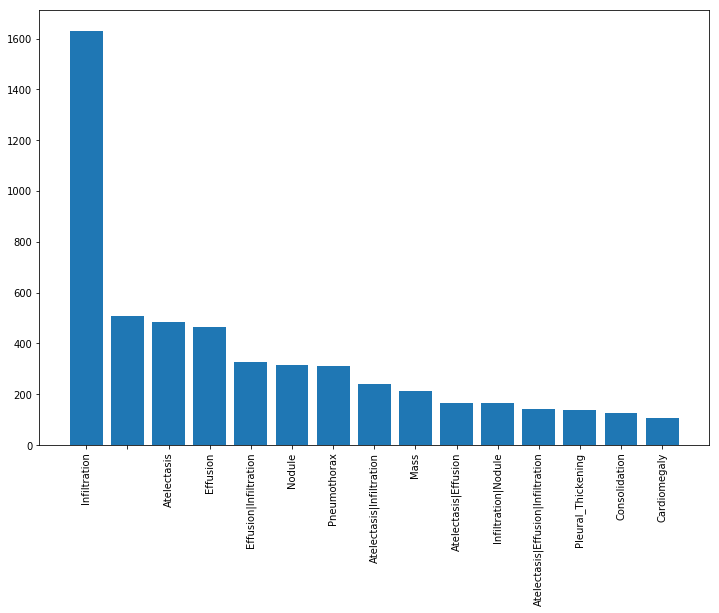

In [7]:
sample_weights = xray_labels_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
xray_labels_df = xray_labels_df.sample(8000, weights = sample_weights)

label_counts = xray_labels_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12,8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5) 
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

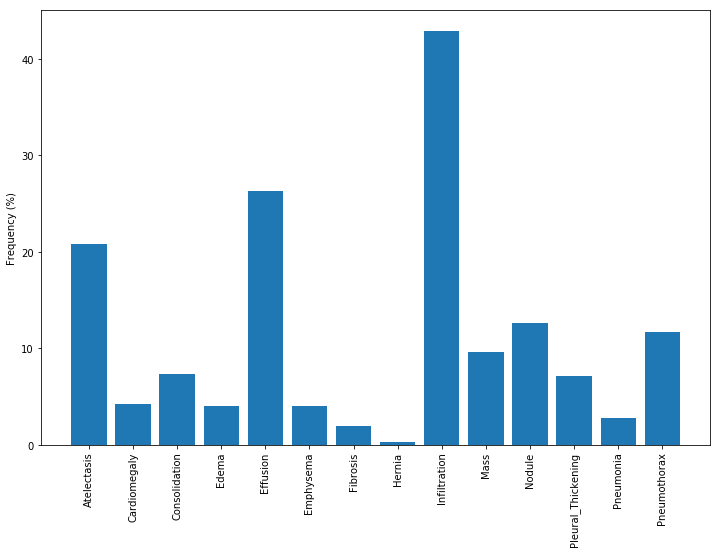

In [8]:
label_counts = 100*np.mean(xray_labels_df[all_labels].values, 0)
fig, ax1 = plt.subplots(1,1, figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
_ = ax1.set_ylabel('Frequency (%)')

Preparing Training Data:
----------------------

In [9]:
# Creates disease vector with values 0 or 1 that model will predict.
xray_labels_df['disease_vec'] = xray_labels_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [10]:
# Splitting data into training and validation sets.
from sklearn.model_selection import train_test_split
training_df, validation_df = train_test_split(xray_labels_df, 
                                              test_size = 0.25, 
                                              random_state = 2018,
                                              stratify = xray_labels_df['Finding Labels'].map(lambda x: x[:4]))

print('train', training_df.shape[0], 'validation', validation_df.shape[0])

train 6000 validation 2000


In [11]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip=True,
                              vertical_flip=True,
                              height_shift_range=0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

/anaconda3/envs/csc665/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    # df_gen is an iterator that yields a tuple (X,Y). 
    # X = batch of images, and Y = corresponding labels.
    return df_gen
    

In [13]:
# Generates training and validation data to be used by models.
training_gen = flow_from_dataframe(core_idg, training_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 32)
validation_gen = flow_from_dataframe(core_idg, validation_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 256)

text_X, test_Y = next(flow_from_dataframe(core_idg, validation_df, path_col ='path', y_col ='disease_vec', target_size = IMG_SIZE, color_mode = 'grayscale', batch_size = 1024))



Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


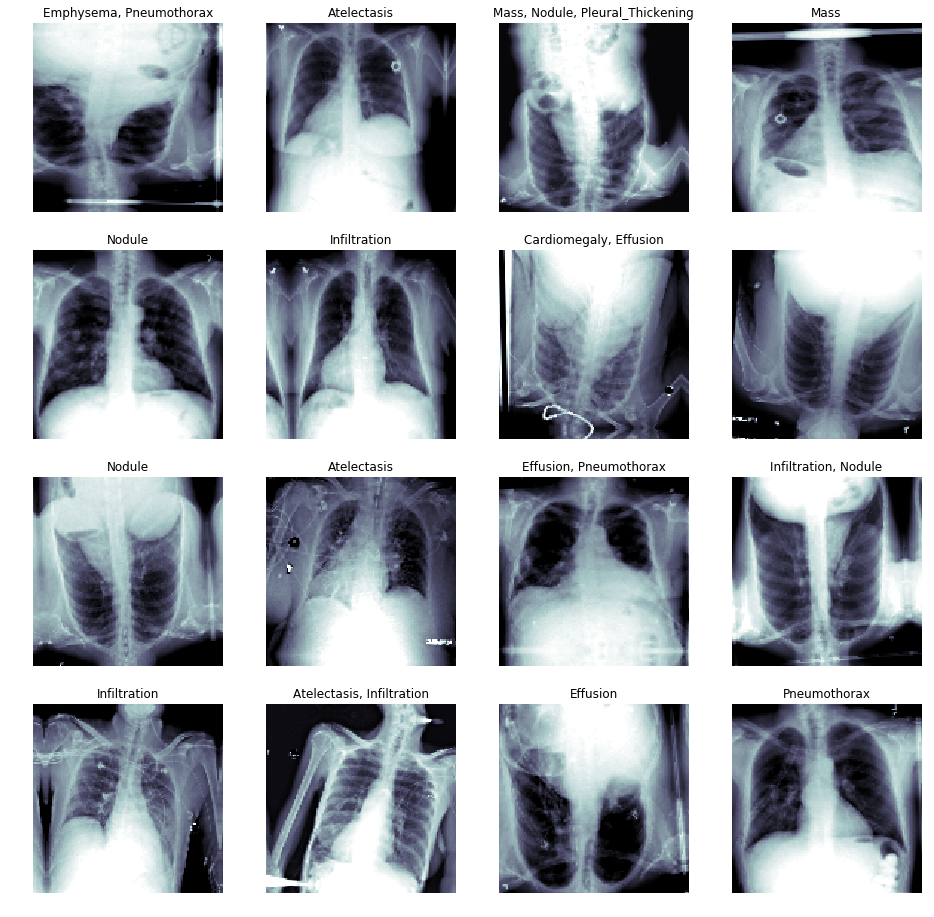

In [14]:
# Visualization
# t_x = images, t_y = labels
t_x, t_y = next(training_gen)
fig, m_axs = plt.subplots(4,4,figsize=(16,16))
for(c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone', vmin=-1.5, vmax=1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score > 0.5]))
    c_ax.axis('off')

Model Creation:
--------------

In [15]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf

print(tf.get_variable_scope())
base_mobilenet_model = MobileNet(input_shape = t_x.shape[1:],
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss ='binary_crossentropy',
                            metric = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                7182      
Total params: 3,760,270
Trainable params: 3,738,382
Non-trainable params: 21,888
_____________________________________________________________

In [16]:
import tensorflow
print(tensorflow.__version__)

1.4.0
